## This notebook displays sleep stages annotations over the recordings and gives the modules to extract awake moments and invalid moments

In [30]:
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')
import mne
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
from tinnsleep.config import Config
from tinnsleep.reports import preprocess, reporting, generate_bruxism_report
from tinnsleep.utils import merge_labels_list
from tinnsleep.data import CreateRaw, RawToEpochs_sliding, CleanAnnotations, AnnotateRaw_sliding
import xlrd
import csv
import time
from datetime import *
print("config loaded")


config loaded


In [21]:
os.chdir("C:/Users/Zeta/Documents/acou_sommeil_HD_ENS/Tinnitus-n-Sleep/notebooks")
os.getcwd()
print(Config.bruxisme_files)

['E:/Acou_sommeil/EDF_V2_PAUL\\1BA07_nuit_hab.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1BA07_nuit_son.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1CC05_nuit_hab.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1CC05_nuit_son.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1DA15_nuit_hab.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1DA15_nuit_son.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1DL12_nuit_hab.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1DL12_nuit_son.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1GB18_nuit_son.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1GB19_nuit_hab.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1GF14_nuit_hab.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1GF14_nuit_son.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1MA16_nuit_hab.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1MA16_nuit_son.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1MF19_nuit_hab.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1MF19_nuit_son.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1MN09_nuit_hab.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1MN09_nuit_son.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\1PI07_nuit_hab.edf', 'E:/Acou_sommeil/EDF_V2_PAUL\\

## XLS to CSV conversion

In [10]:
current_folder = os.getcwd()
#Listing xls files to be converted
xls_sleep_staging=os.listdir(current_folder + "/data/sleep_staging/")
os.chdir(current_folder + "/data/sleep_staging/")
for file in xls_sleep_staging:
        print(file)
        os.chdir(current_folder + "/data/sleep_staging/")
        #Reading excel file
        data_xls = pd.read_excel(file, 'Sheet1', index_col=None)
        os.chdir(current_folder + "/data/sleep_staging_csv/")
        #saving to csv format
        data_xls.to_csv(file[:-4]+'.csv', encoding='latin-1', sep=";")
os.chdir(current_folder)

1MF19_nuit_son.xls
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
HZB_nuit_2.xls
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
HZB_nuit_2_resmed.xls
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
HZB_nuit_3.xls
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
jon_mema.xls
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
mema 150120.xls
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
sophie_mema.xls
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
tom_mema.xls
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
unger_2.xls
unger_nuit_3.xls
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


## Preprocessing of CSV files:
- Adding invalid epochs
- determining sleep onset epoch and memorizing it
- determining final awakening epoch and memorizing it

In [20]:
current_folder = os.getcwd()
os.chdir(current_folder + "/data/sleep_staging_csv/")
csv_sleep_staging=os.listdir(current_folder + "/data/sleep_staging_csv/")
all_s_stages=[]
for file in csv_sleep_staging:
    print(file)
    df = pd.read_csv(file, sep=";", encoding='latin-1')
    # Retrieving the timestamps of each epoch
    get_eps=df["Horodatage"].tolist()[1:]  # Getting rid of the first element which is an empty list
    get_eps=[get_eps[i].split(" ")[1] for i in range(len(get_eps))] #getting only the hour
    # Retrieving the sleep stage of each epoch
    get_stages = df["Sommeil"].tolist()[1:]    # Getting rid of the first element which is an empty list

    
    # ------------- detecting missing epochs and completing sleep stages with invalid labels -------------
    #initialisation of a new sleep stages list
    sleep_stages=[get_stages[0]]
    for i in range(len(get_eps)-1):
        #getting time difference between two consecutive epochs. It should be of 30 seconds
        var = datetime.strptime(get_eps[i], '%H:%M:%S')
        var2 = datetime.strptime(get_eps[i+1], '%H:%M:%S')
        diff = int((var2-var).total_seconds())
        #case where we pass midnight
        if diff < 0:
            diff = 3600*24 + int((var2-var).total_seconds())
        
        #Deals when there is one or more epochs missing
        if diff>30:
            if diff== 60: #in this case, we have only one epoch missing,
                # we can assume in this case that the sleep stage has not changed and we just rewrite the preceding value
                sleep_stages.append(sleep_stages[-1])
                #We add the next sleep stage to the list
                sleep_stages.append(get_stages[i+1])
            else:
                #If we miss more than one epoch, we add several invalid labels for all missing epochs
                for j in range(int(diff/30)-1):
                    sleep_stages.append("Invalid")
                #We add the next sleep stage to the list
                sleep_stages.append(get_stages[i+1])
        else:
            #We add the next sleep stage to the list
            sleep_stages.append(get_stages[i+1])
            
    
    # ------------- finding the first sleep onset and the last awakening -------------
    flag_endor=False
    flag_rev=False
    labs=["Éveil", "Invalid", np.nan, "eveil"]  #different cases where the patient is considered awake
    for i in range(len(sleep_stages)):
        #detecting first sleep onset
        if not labs.__contains__(sleep_stages[i]):
            if not flag_endor:
                ind_deb=i
                flag_endor=True
        #detecting last asleep moment
        if not labs.__contains__(sleep_stages[-i-1]):

            if not flag_rev:
                ind_fin=i
                flag_rev=True
    #assessing time of sleep onset
    deb = datetime.strptime(get_eps[0], '%H:%M:%S')+ timedelta(seconds=ind_deb*30)
    #assessing time of the final awakening
    fin = datetime.strptime(get_eps[-1], '%H:%M:%S')- timedelta(seconds=ind_fin*30)
  
    
    #Storing results for future use
    if ind_fin>0:
        all_s_stages.append([file, sleep_stages[ind_deb:-ind_fin], deb.time(), fin.time()])
    else: #we go until the end of slee_stages
        all_s_stages.append([file, sleep_stages[ind_deb:], deb.time(), fin.time()])
    print("Duration of the sleep period")
    print(timedelta(seconds=len(all_s_stages[-1][1])*30))
os.chdir(current_folder)

1MF19_nuit_son.csv
Duration of the sleep period
9:32:00
HZB_nuit_2.csv
Duration of the sleep period
6:54:00
HZB_nuit_2_resmed.csv
Duration of the sleep period
6:56:30
HZB_nuit_3.csv
Duration of the sleep period
6:53:00
jon_mema.csv
Duration of the sleep period
8:30:00
mema 150120.csv
Duration of the sleep period
7:51:30
sophie_mema.csv
Duration of the sleep period
6:58:00
tom_mema.csv
Duration of the sleep period
6:55:30
unger_2.csv
Duration of the sleep period
7:54:00
unger_nuit_3.csv
Duration of the sleep period
8:29:30


## Sleep stage visualisation on awaken-cropped recording :

E:/Acou_sommeil/EDF_V2_PAUL
Extracting EDF parameters from E:\Acou_sommeil\EDF_V2_PAUL\1MF19_nuit_son.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
start of the recording
1900-01-01 21:18:03
start of the first sleep annotation
1900-01-01 21:33:00
end of the last sleep annotation
1900-01-01 07:04:30
1900-01-02 07:05:00
end of the recording
1900-01-02 07:06:53


<ipython-input-31-187d9ba25cfe>:11: RuntimeWarning: 7 channel names are too long, have been truncated to 15 characters:
['Inductance Abdom', 'Inductance Thora', 'Intensit? lumine', 'Jambe droite Imp', 'Jambe gauche Imp', 'Tension (aliment', 'Tension (Bluetoo']
  RAW  = mne.io.read_raw_edf(edf_file, preload=False)  # prepare loading


[-1.36246772e-05 -1.71283630e-05 -1.73031963e-05 ... -2.30934300e-04
 -2.11653557e-04 -2.04991622e-04]
Raw annotated


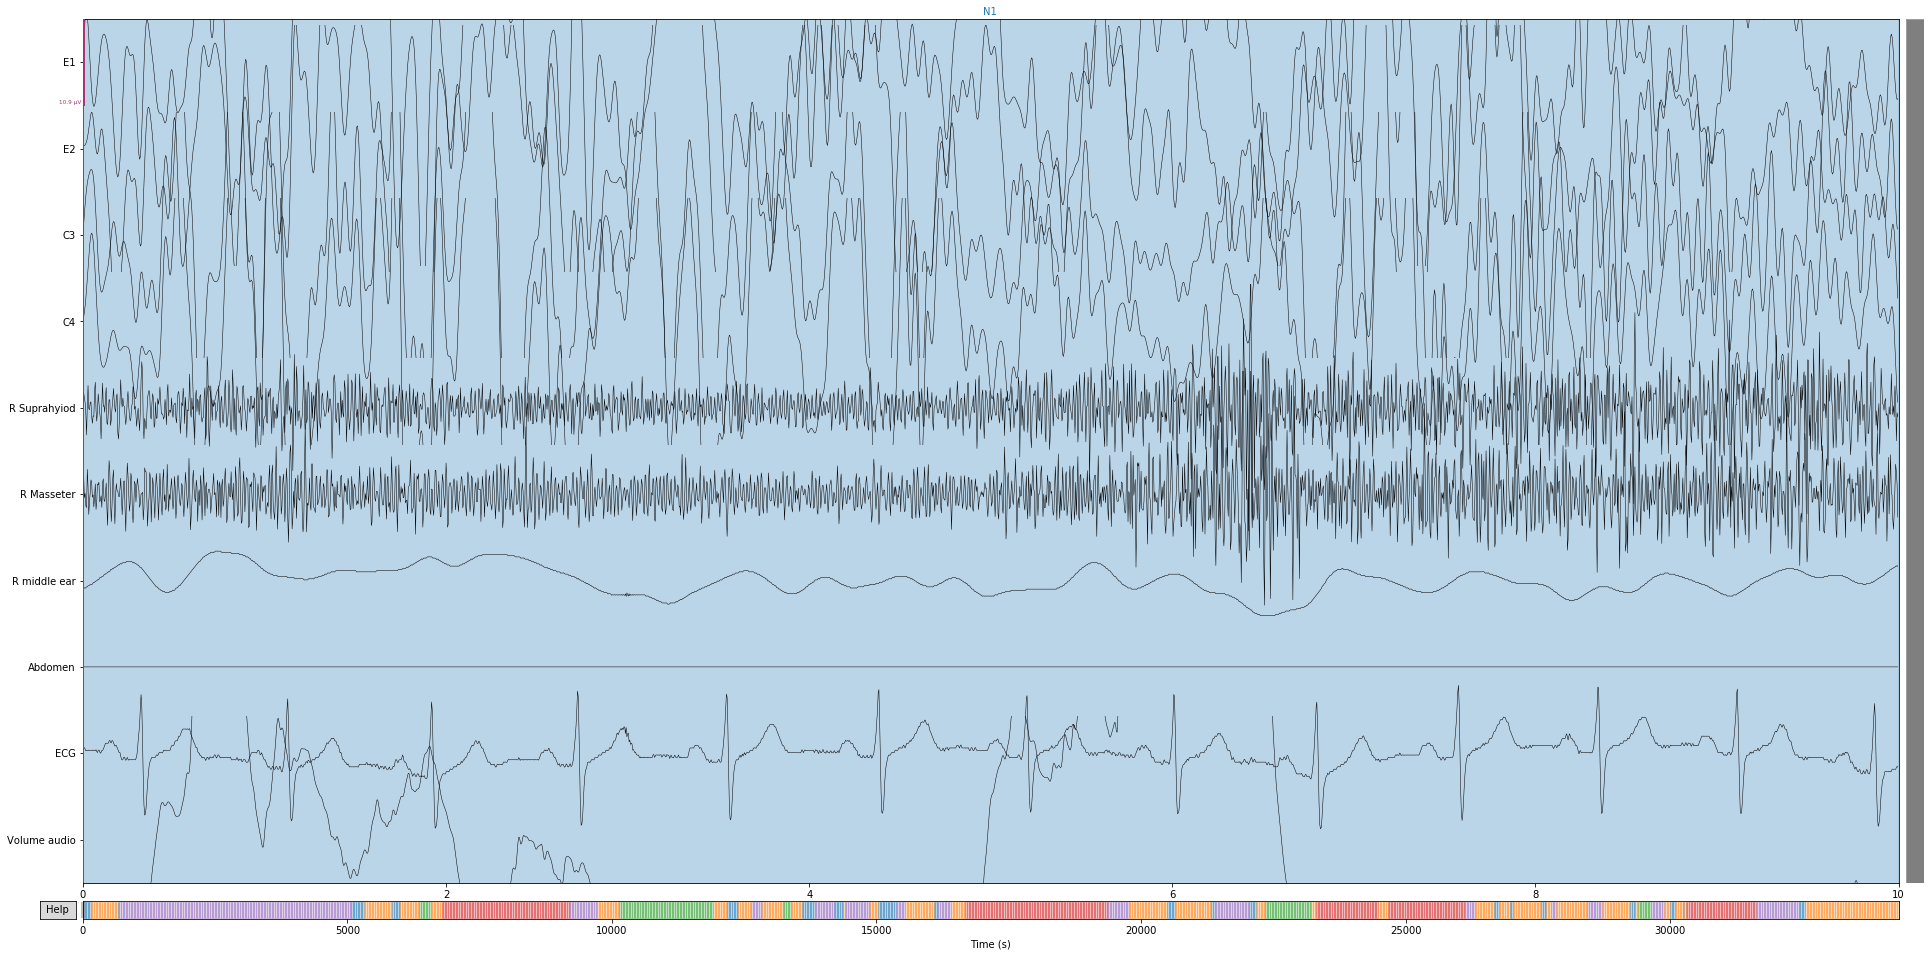

E:/Acou_sommeil/EDF_V2_PAUL
Extracting EDF parameters from E:\Acou_sommeil\EDF_V2_PAUL\HZB_nuit_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
start of the recording
1900-01-01 00:35:08
start of the first sleep annotation
1900-01-01 00:38:30
end of the last sleep annotation
1900-01-01 07:32:00
1900-01-01 07:32:30
end of the recording
1900-01-01 07:33:08


<ipython-input-31-187d9ba25cfe>:11: RuntimeWarning: 6 channel names are too long, have been truncated to 15 characters:
['Inductance Abdom', 'Inductance Thora', 'Jambe droite Imp', 'Jambe gauche Imp', 'Tension (aliment', 'Tension (Bluetoo']
  RAW  = mne.io.read_raw_edf(edf_file, preload=False)  # prepare loading


[-5.39051485e-06 -6.88882107e-06 -1.69774163e-05 ... -3.19299905e-06
 -1.99435408e-06 -7.18848231e-06]
Raw annotated


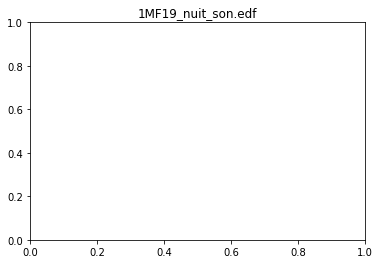

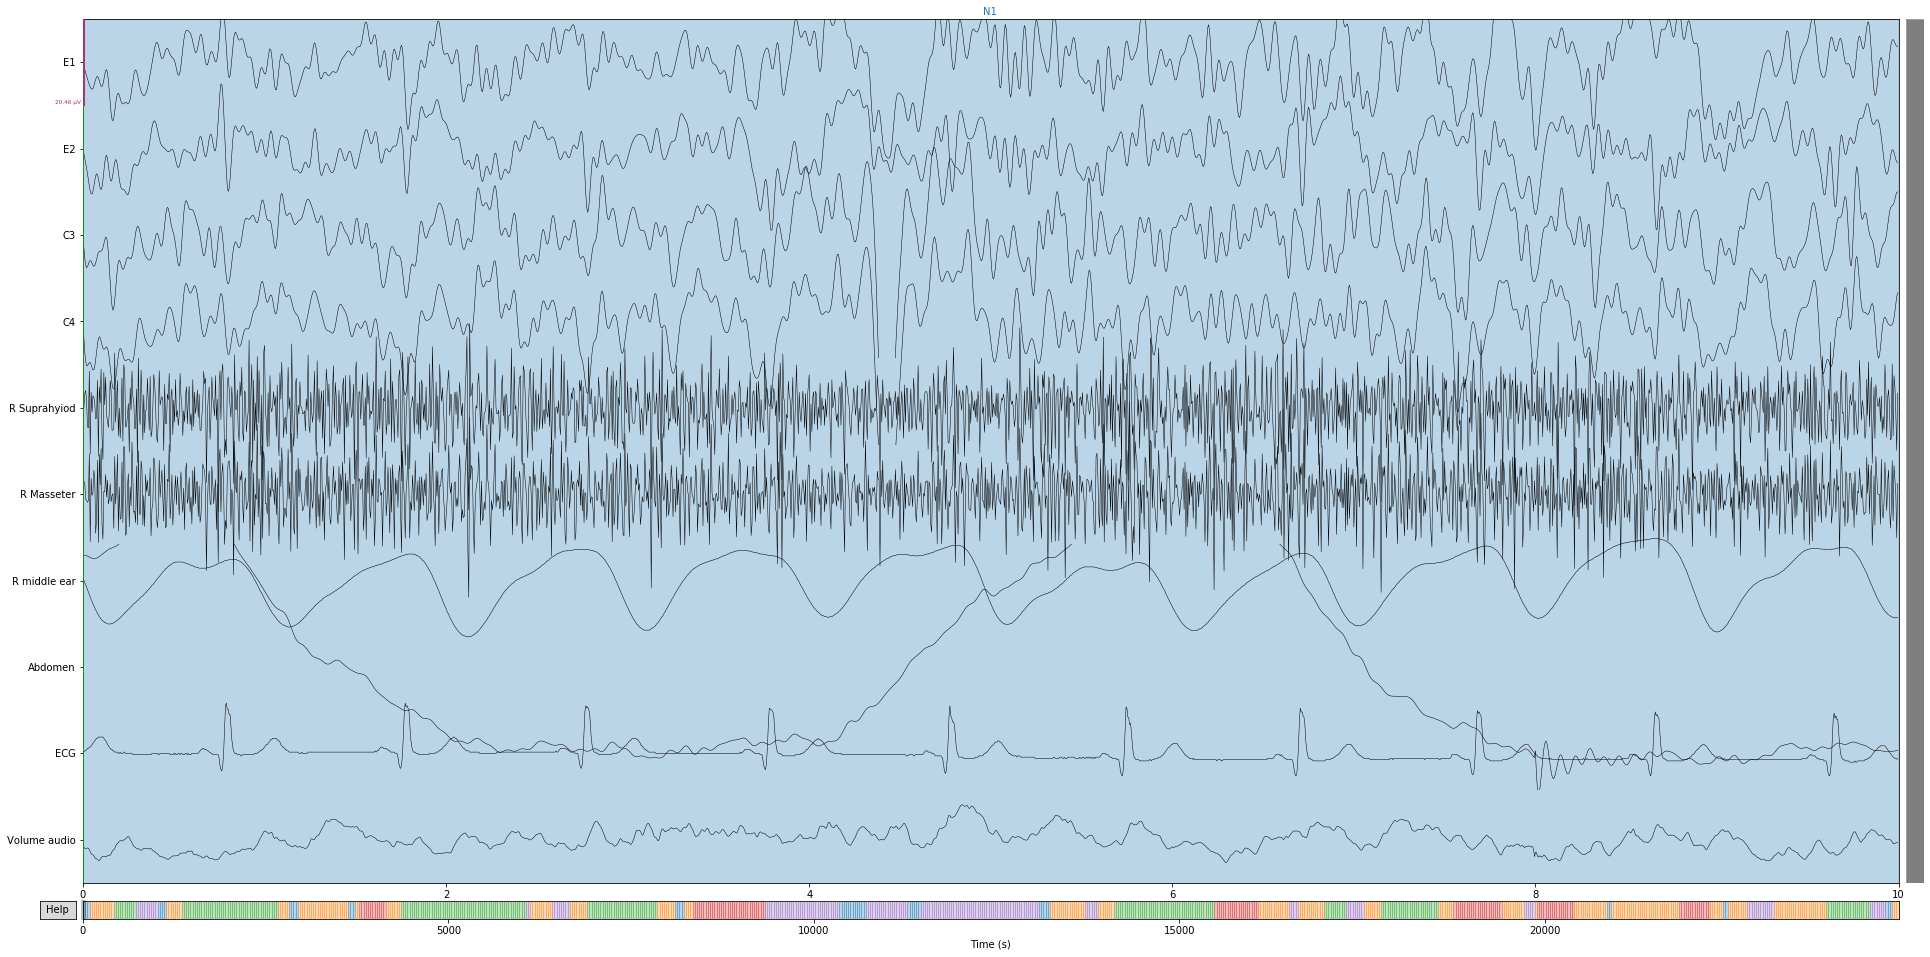

E:/Acou_sommeil/EDF_V2_PAUL
E:/Acou_sommeil/EDF_V2_PAUL
Extracting EDF parameters from E:\Acou_sommeil\EDF_V2_PAUL\HZB_nuit_3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
start of the recording
1900-01-01 00:48:38
start of the first sleep annotation
1900-01-01 00:51:30
end of the last sleep annotation
1900-01-01 07:44:00
1900-01-01 07:44:30
end of the recording
1900-01-01 07:44:48


<ipython-input-31-187d9ba25cfe>:11: RuntimeWarning: 6 channel names are too long, have been truncated to 15 characters:
['Inductance Abdom', 'Inductance Thora', 'Jambe droite Imp', 'Jambe gauche Imp', 'Tension (aliment', 'Tension (Bluetoo']
  RAW  = mne.io.read_raw_edf(edf_file, preload=False)  # prepare loading


[ 3.85598010e-05  3.48639790e-05  3.95586718e-05 ... -9.48588519e-06
 -9.78554643e-06 -1.01850948e-05]
Raw annotated


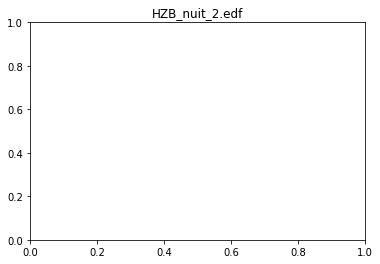

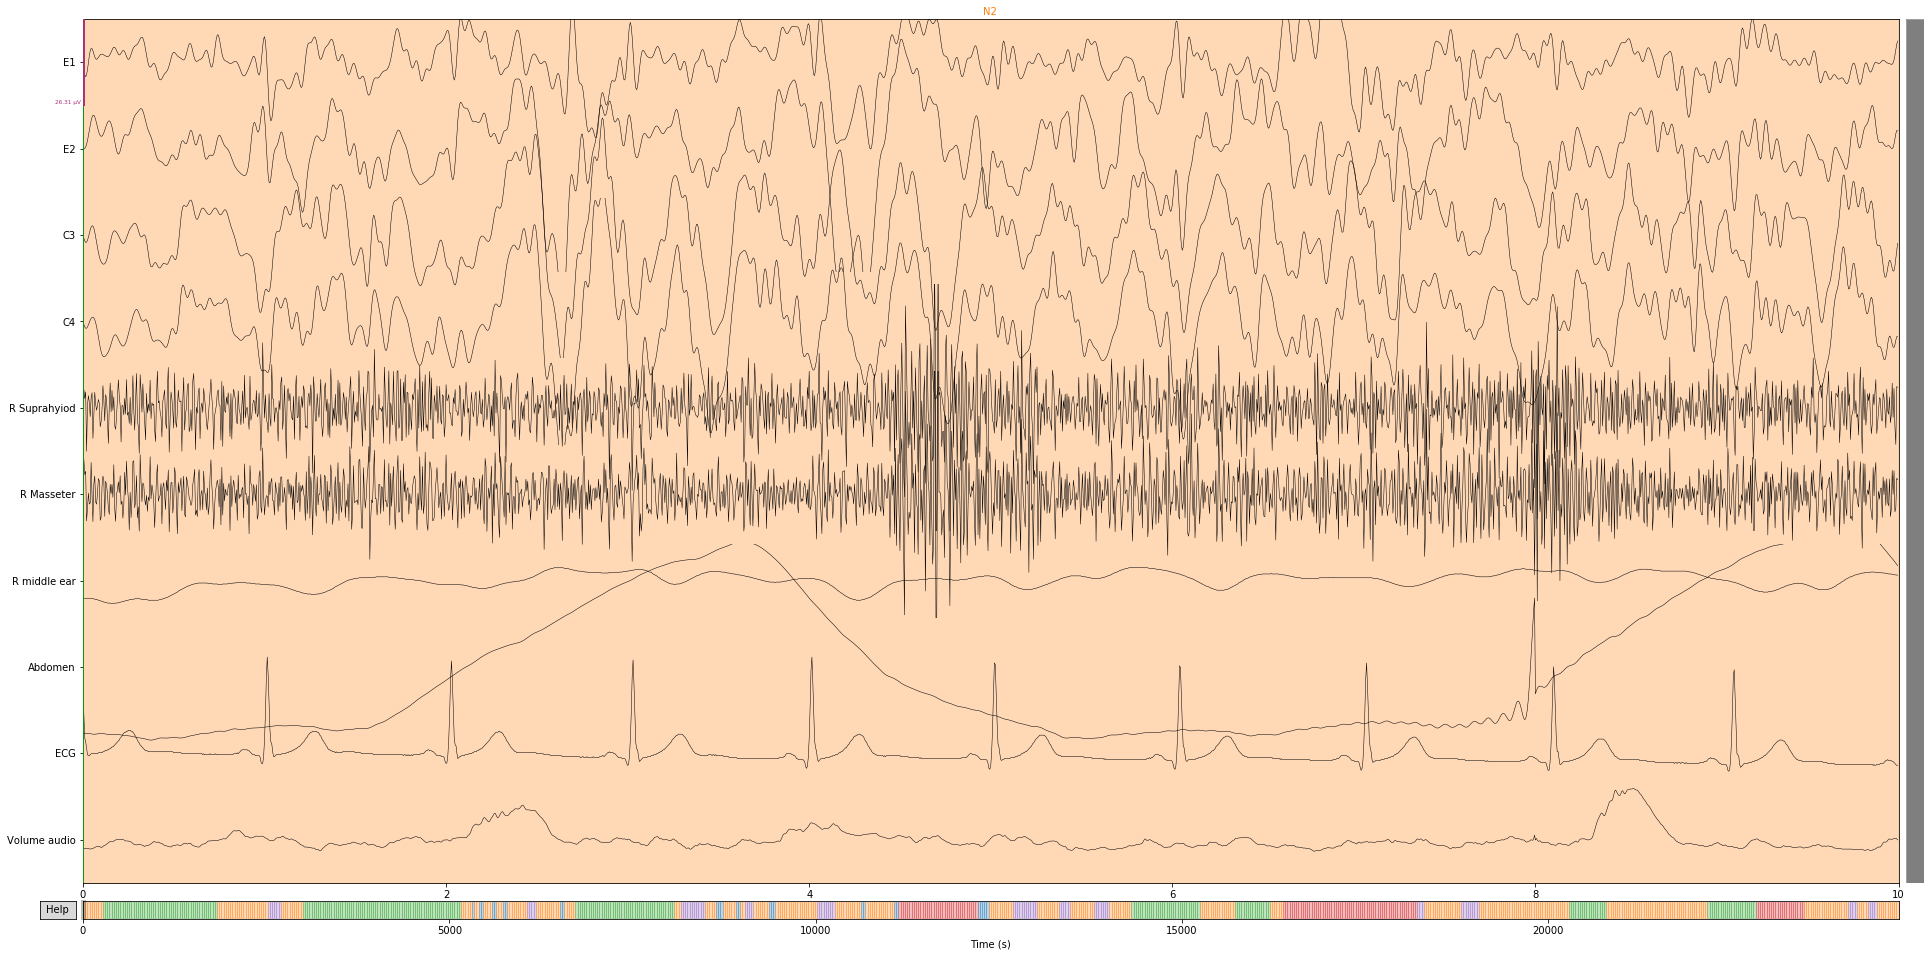

E:/Acou_sommeil/EDF_V2_PAUL
Extracting EDF parameters from E:\Acou_sommeil\EDF_V2_PAUL\jon_mema.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
start of the recording
1900-01-01 22:10:04
start of the first sleep annotation
1900-01-01 22:53:30
end of the last sleep annotation
1900-01-01 07:23:00
1900-01-02 07:23:30
end of the recording
1900-01-02 07:31:24


<ipython-input-31-187d9ba25cfe>:11: RuntimeWarning: 7 channel names are too long, have been truncated to 15 characters:
['Inductance Abdom', 'Inductance Thora', 'Intensit? lumine', 'Jambe droite Imp', 'Jambe gauche Imp', 'Tension (aliment', 'Tension (Bluetoo']
  RAW  = mne.io.read_raw_edf(edf_file, preload=False)  # prepare loading


[ 1.41743156e-04  4.00475630e-05 -3.09909085e-05 ...  1.12576513e-04
  7.39666368e-05  5.67392499e-05]
Raw annotated


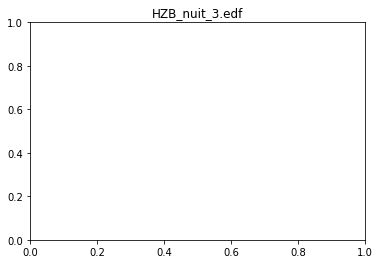

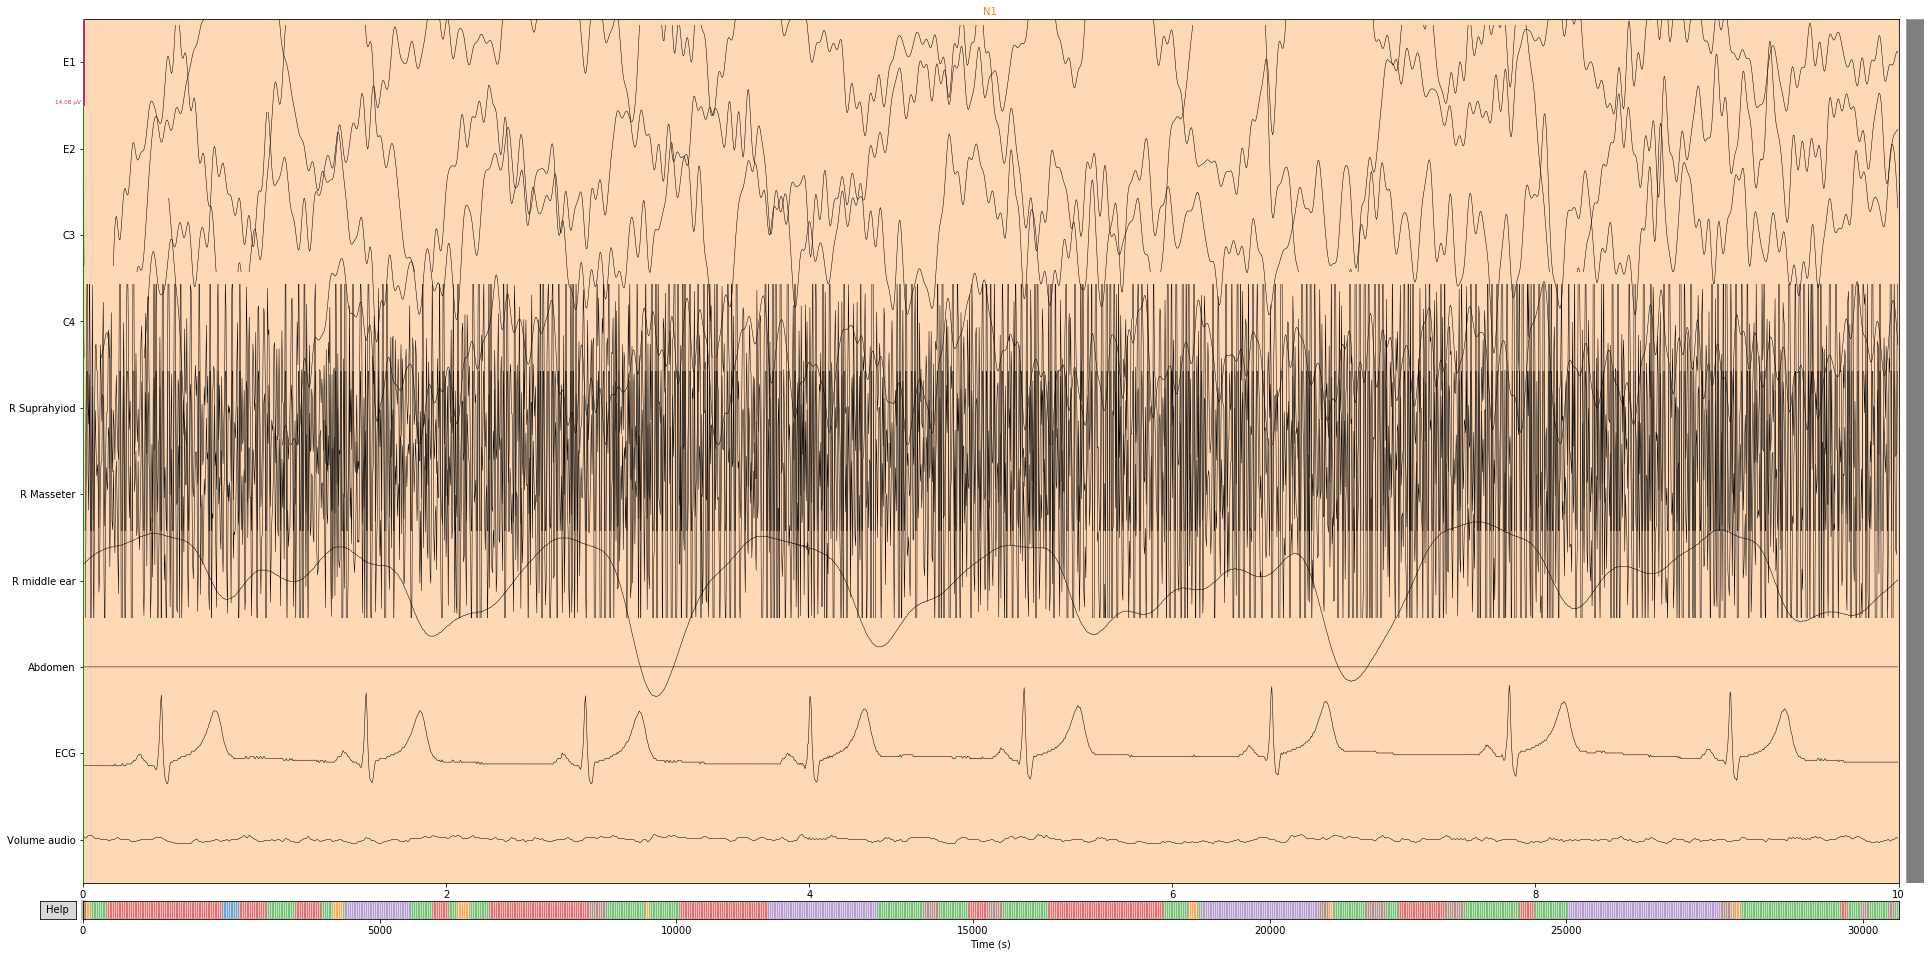

E:/Acou_sommeil/EDF_V2_PAUL
E:/Acou_sommeil/EDF_V2_PAUL
Extracting EDF parameters from E:\Acou_sommeil\EDF_V2_PAUL\sophie_mema.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
start of the recording
1900-01-01 01:59:27
start of the first sleep annotation
1900-01-01 02:03:00
end of the last sleep annotation
1900-01-01 09:00:30
1900-01-01 09:01:00
end of the recording
1900-01-01 09:01:07


<ipython-input-31-187d9ba25cfe>:11: RuntimeWarning: 7 channel names are too long, have been truncated to 15 characters:
['Inductance Abdom', 'Inductance Thora', 'Intensit? lumine', 'Jambe droite Imp', 'Jambe gauche Imp', 'Tension (aliment', 'Tension (Bluetoo']
  RAW  = mne.io.read_raw_edf(edf_file, preload=False)  # prepare loading


[ 0.00014794  0.00015566  0.00014807 ... -0.0003746  -0.00037529
 -0.00036858]
Raw annotated


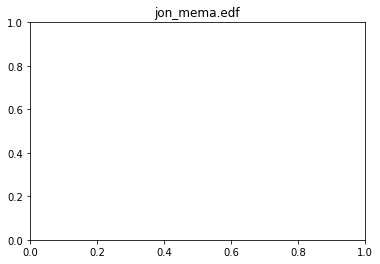

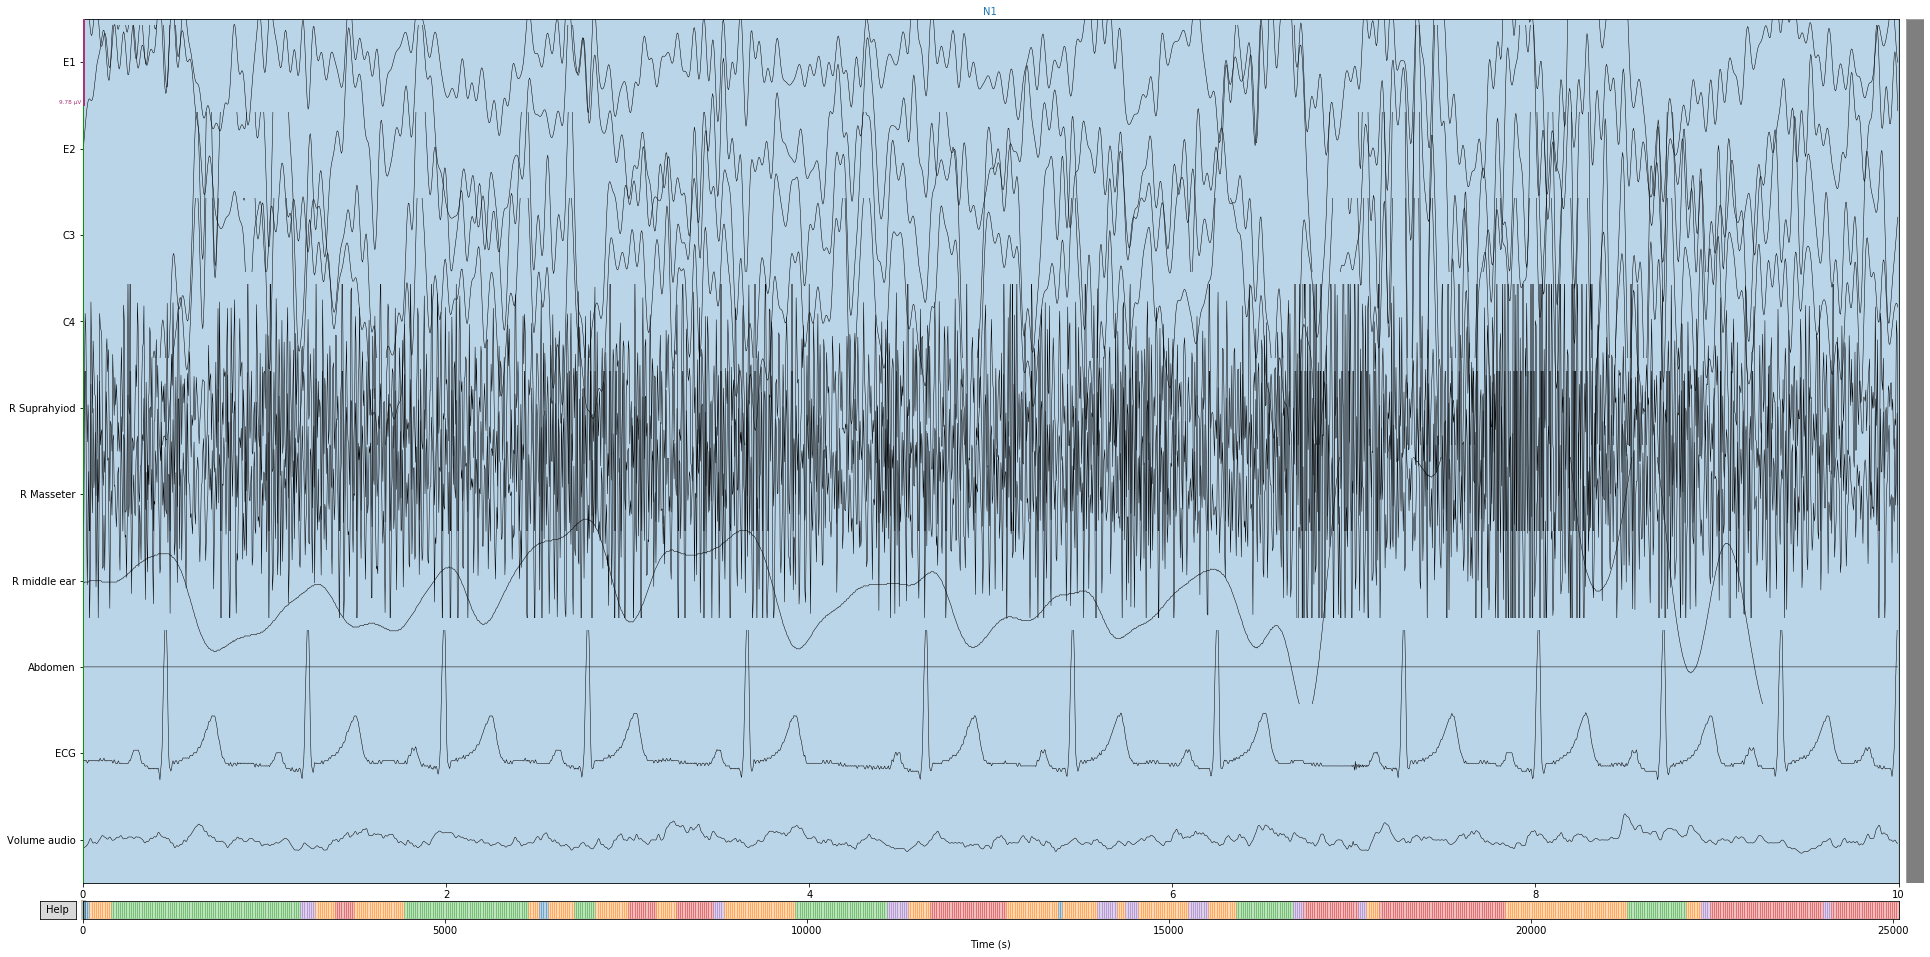

E:/Acou_sommeil/EDF_V2_PAUL
Extracting EDF parameters from E:\Acou_sommeil\EDF_V2_PAUL\tom_mema.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
start of the recording
1900-01-01 00:24:03
start of the first sleep annotation
1900-01-01 00:29:00
end of the last sleep annotation
1900-01-01 07:24:00
1900-01-01 07:24:30
end of the recording
1900-01-01 07:24:53


<ipython-input-31-187d9ba25cfe>:11: RuntimeWarning: 7 channel names are too long, have been truncated to 15 characters:
['Inductance Abdom', 'Inductance Thora', 'Intensit? lumine', 'Jambe droite Imp', 'Jambe gauche Imp', 'Tension (aliment', 'Tension (Bluetoo']
  RAW  = mne.io.read_raw_edf(edf_file, preload=False)  # prepare loading


[-2.95631886e-05 -3.00092571e-05 -2.90060007e-05 ...  6.30620327e-05
  6.57520299e-05  6.77268288e-05]
Raw annotated


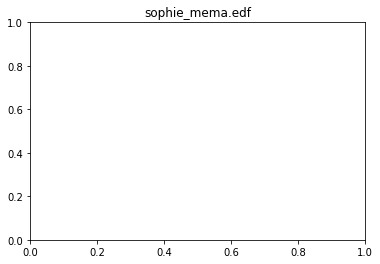

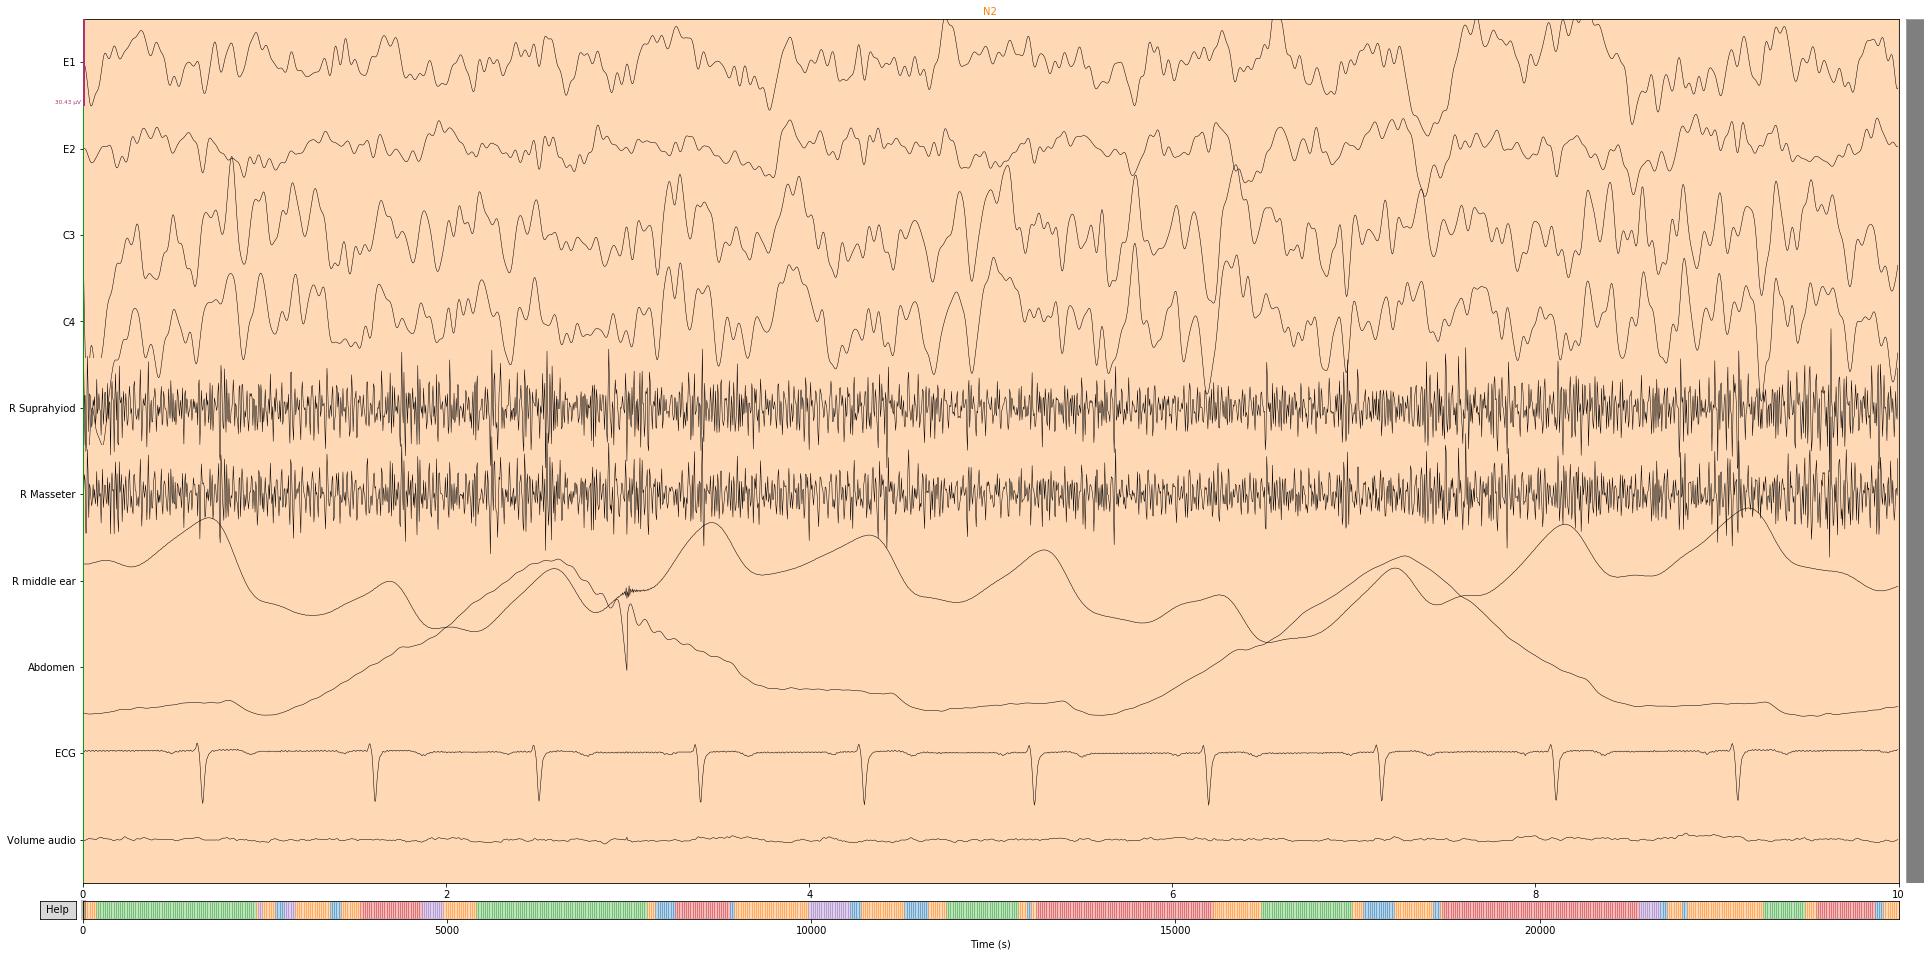

E:/Acou_sommeil/EDF_V2_PAUL
E:/Acou_sommeil/EDF_V2_PAUL
Extracting EDF parameters from E:\Acou_sommeil\EDF_V2_PAUL\unger_nuit_3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
start of the recording
1900-01-01 23:29:59
start of the first sleep annotation
1900-01-01 23:30:00
end of the last sleep annotation
1900-01-01 07:59:00
1900-01-02 07:59:30
end of the recording
1900-01-02 08:01:19


<ipython-input-31-187d9ba25cfe>:11: RuntimeWarning: 6 channel names are too long, have been truncated to 15 characters:
['Inductance Abdom', 'Inductance Thora', 'Jambe droite Imp', 'Jambe gauche Imp', 'Voltage (battery', 'Voltage (bluetoo']
  RAW  = mne.io.read_raw_edf(edf_file, preload=False)  # prepare loading


[4.90479446e-05 4.57516709e-05 5.10456862e-05 ... 2.30773034e-05
 2.41760613e-05 2.30773034e-05]
Raw annotated


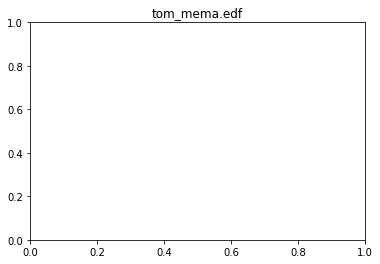

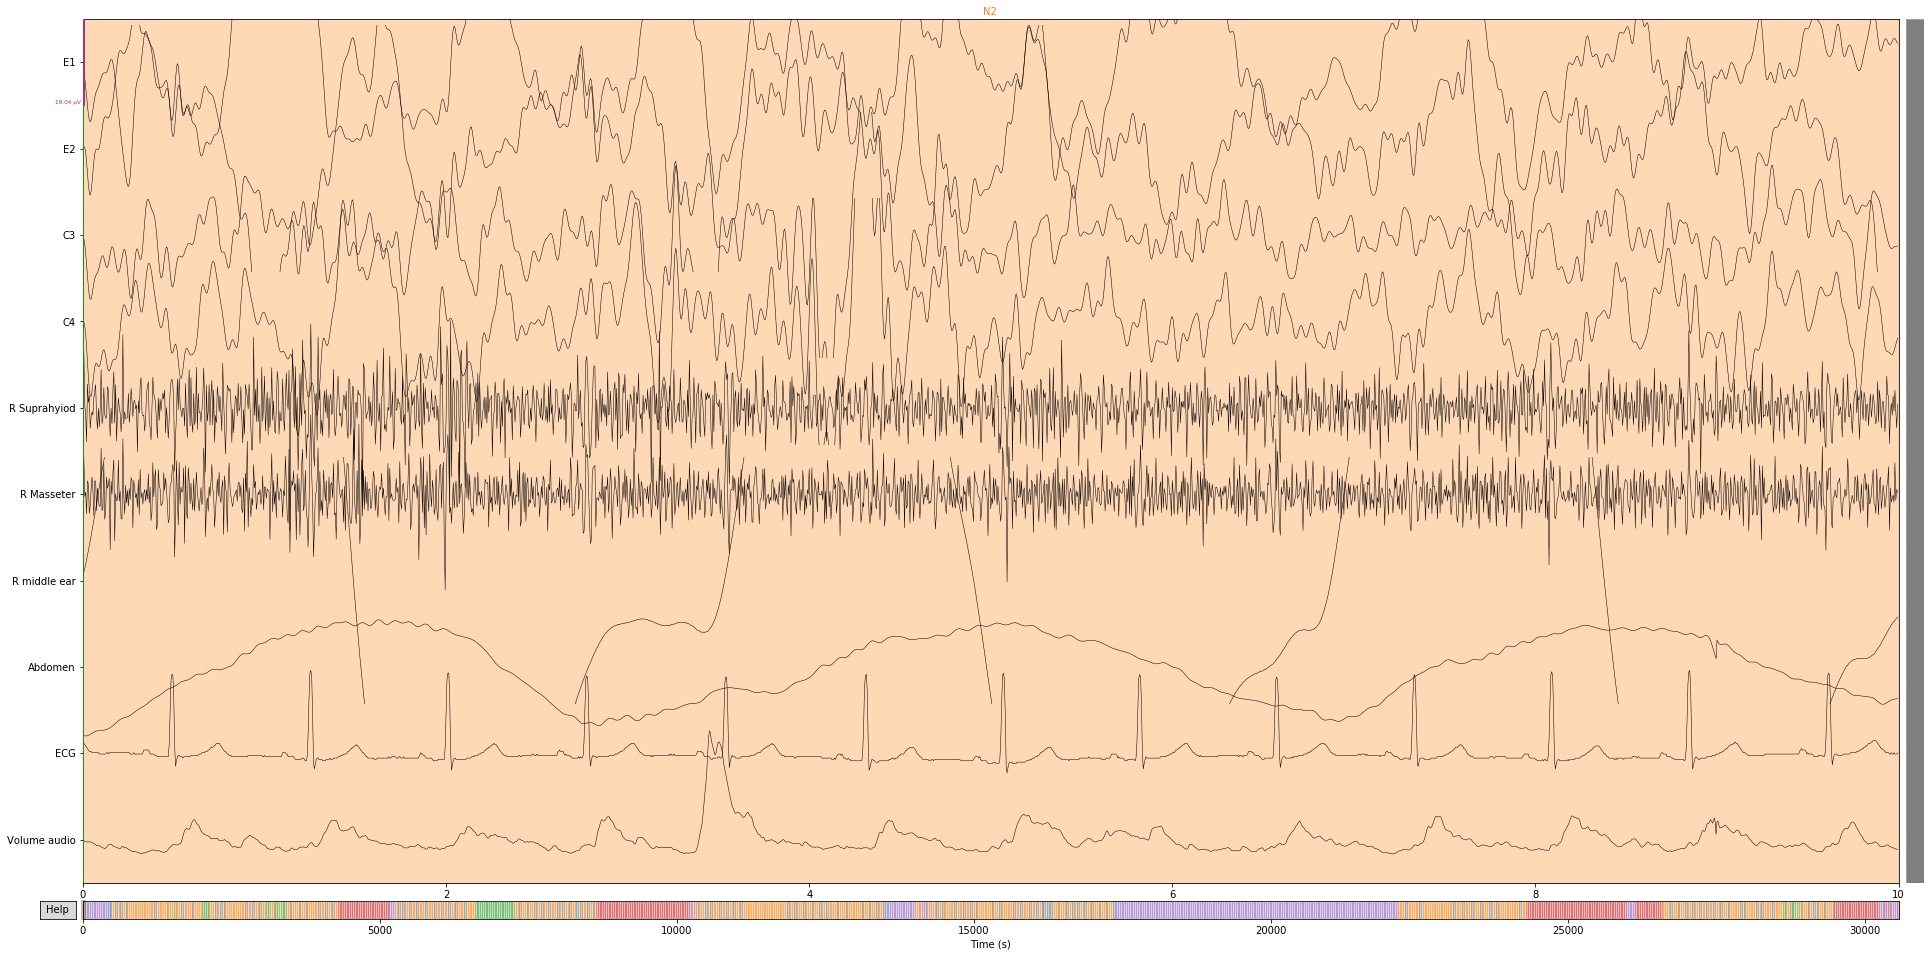

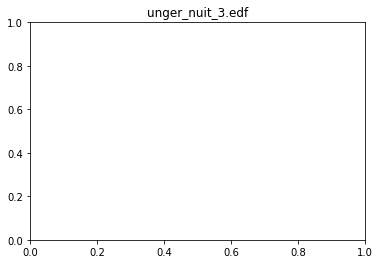

In [31]:
get_repo = Config.bruxisme_files
for elm in all_s_stages:
    #dealing with files matching between repositories
    file = elm[0]
    filename= file[:-4]+".edf"
    general_path = "".join(get_repo[0].split(os.path.sep)[0])
    print(general_path)
    edf_file = general_path+os.path.sep+filename
    if get_repo.__contains__(edf_file): #when we find a matched edf file
        
        RAW  = mne.io.read_raw_edf(edf_file, preload=False)  # prepare loading
        
        #Details about the recording
        print("start of the recording")
        print(datetime.strptime(str(RAW.info["meas_date"].time()), '%H:%M:%S'))
        print("start of the first sleep annotation")
        print(datetime.strptime(str(elm[-2]), '%H:%M:%S'))
        print("end of the last sleep annotation")
        print(datetime.strptime(str(elm[-1]), '%H:%M:%S'))
        print(datetime.strptime(str(elm[-2]), '%H:%M:%S') + timedelta(seconds=len(elm[1])*30) )
        print("end of the recording")
        print(datetime.strptime(str(RAW.info["meas_date"].time()), '%H:%M:%S') +timedelta(seconds=len(RAW)/RAW.info["sfreq"]))
        
        
        #Cropping Raw between sleep onset and first awakening
        tmin_sleep=(datetime.strptime(str(elm[-2]), '%H:%M:%S') - datetime.strptime(str(RAW.info["meas_date"].time()), '%H:%M:%S')).total_seconds()
        tmax_sleep = (datetime.strptime(str(elm[-1]), '%H:%M:%S') - datetime.strptime(str(RAW.info["meas_date"].time()), '%H:%M:%S')).total_seconds()
        if tmax_sleep < 0:
            tmax_sleep = 3600*24 + tmax_sleep
        croptimes=dict(tmin=tmin_sleep, tmax=tmax_sleep+30)
        RAW.crop(**croptimes)
        
        
        #Preparing raw for visualisation
        chan = RAW.info["ch_names"]
        picks_chan = ["E1","E2", 'C3', 'C4', '1', '2',"Airflow",'Abdomen', 'ECG', "Volume audio"]
        RAW  = CreateRaw(RAW[picks_chan][0], RAW.info["sfreq"], picks_chan, ch_types='emg')        # pick channels and load
        RAW  = RAW.load_data()
        dat=RAW.get_data()
        dat[-2]=[dat[-2][i]*0.01 for i in range(len(dat[1]))]
        dat[-4]=[dat[-4][i]*0.0005 for i in range(len(dat[1]))]
        dat[-1]=[dat[-1][i]*0.0005 for i in range(len(dat[1]))]
        RAW  = CreateRaw(dat, RAW.info["sfreq"], picks_chan, ch_types='emg') 
        RAW  = RAW.filter(20., 99., n_jobs=4, 
                          fir_design='firwin', filter_length='auto', phase='zero-double',
                          picks=['1', '2'])
        RAW  = RAW.filter(1., 20., n_jobs=4, 
                          fir_design='firwin', filter_length='auto', phase='zero-double',
                          picks=["E1","E2", 'C3', 'C4'])
        RAW.rename_channels({'Airflow': 'R middle ear', '1':'R Suprahyiod', '2': 'R Masseter' })
        #-----------------labelling datas with sleep stages annotations -----------------------------------
        #Annotating the raw
        RAW = CleanAnnotations(RAW)
        dict_annotations = {"awake": "awake", "N1":"N1", "N2":"N2", "N3":"N3", "REM":"REM"}
        RAW = AnnotateRaw_sliding(RAW, elm[1], 
                        dict_annotations=dict_annotations, duration=RAW.info["sfreq"]*30, interval=RAW.info["sfreq"]*30)

        print("Raw annotated")
        RAW.plot(scalings = "auto")